# FastAI Vision from Fastbook

In [ ]:
!git clone https://github.com/fastai/fastbook.git
%cd fastbook
!pip install -r requirements.txt

In [ ]:
from utils import *
from fastai2.vision.widgets import *

In [ ]:
from fastai2.vision.all import *

In [ ]:
path = untar_data(URLs.PETS)/'images'
dbunch = ImageDataLoaders.from_name_func(path, get_image_files(path), valid_pct=0.2, 
                                       label_func=lambda x: x[0].isupper(),
                                       item_tfms = Resize(224))
learn = cnn_learner(dbunch, resnet34, metrics=error_rate)
learn.fine_tune(2)

In [ ]:
img = PILImage.create('/content/dog_test.jpg')
is_cat,_,probs = learn.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

Is this a cat?: False.
Probability it's a cat: 0.000045


In [ ]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

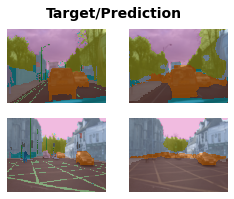

In [ ]:
learn.show_results(max_n=6, figsize=(4,3))

In [ ]:
from fastai2.text.all import *

In [ ]:
dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

In [ ]:
learn.predict("This was a time pass and not good")

[How to determine if cattle are bulls, steers, cows or heifers](https://www.farmanddairy.com/top-stories/how-to-determine-if-cattle-are-bulls-steers-cows-or-heifers/274534.html)

In [ ]:
# bing image search api
key = '519a49fbf31549b2adf45c926f85b679'
results = search_images_bing(key, 'bull cattle')
ims = results.attrgot('content_url')
len(ims)

150

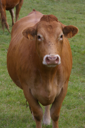

In [ ]:
dest = 'images/bullx.jpg'
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

In [ ]:
cattle_types = 'bull','steer','cow','heifer'
path = Path('cattles')

# download the images
if not path.exists():
    path.mkdir()
    for o in cattle_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} cattle')
        download_images(dest, urls=results.attrgot('content_url'))

# verify the images
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink)

(#7) [None,None,None,None,None,None,None]

In [ ]:
# from data to dataloaders
cattles = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    get_items=get_image_files,
                    splitter=RandomSplitter(valid_pct=0.2, seed=42),
                    get_y=parent_label,
                    item_tfms=Resize(128))

dls = cattles.dataloaders(path)

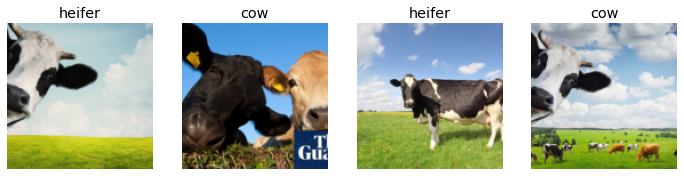

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

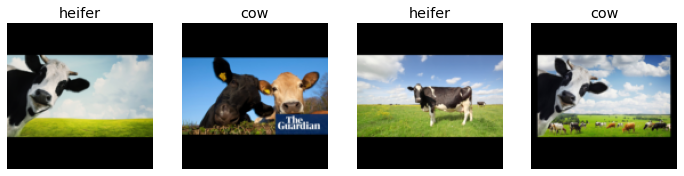

In [ ]:
cattles = cattles.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = cattles.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

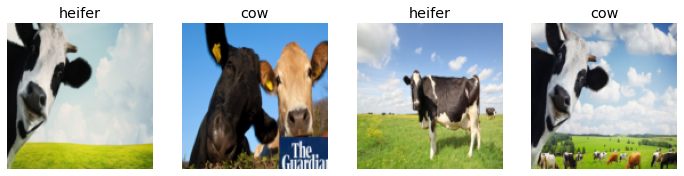

In [ ]:
cattles = cattles.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = cattles.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

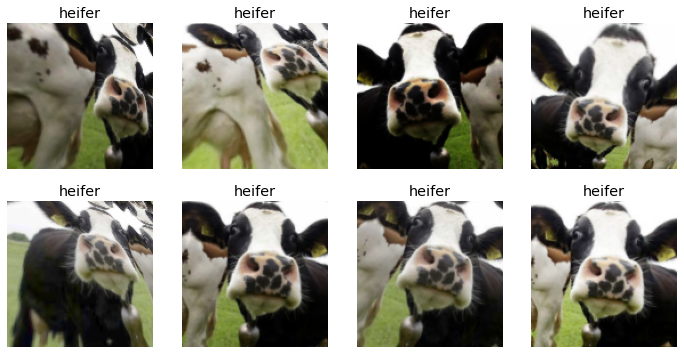

In [ ]:
# data augmentation
cattles = cattles.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = cattles.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

We don't have a lot of data for our problem (150 pictures of each sort of cattle at most), so to train our model, we'll use RandomResizedCrop with an image size of 224 px, which is fairly standard for image classification, and default aug_transforms:

In [ ]:
cattles = cattles.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
                      batch_tfms=aug_transforms())
dls = cattles.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,2.379534,2.244768,0.709402,00:18


epoch,train_loss,valid_loss,error_rate,time
0,1.990498,1.966865,0.709402,00:19
1,1.875243,2.363744,0.709402,00:19
2,1.742805,2.482710,0.743590,00:19
3,1.636921,2.556281,0.786325,00:19


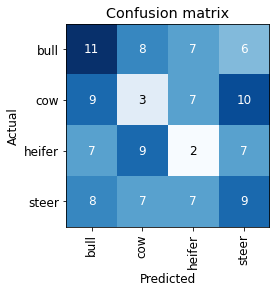

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

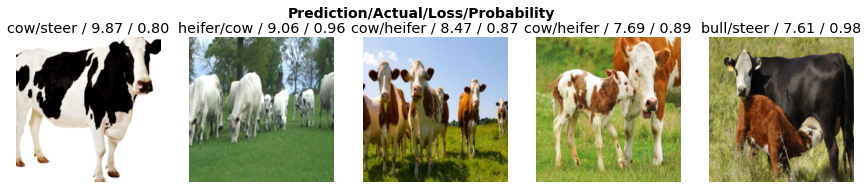

In [ ]:
interp.plot_top_losses(5, nrows=1)